# Import des librairies

In [2]:
%%time
import time
init_time = time.time()

import os
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Installation du package gensim
!pip install gensim
import gensim
from gensim.models import Word2Vec

import numpy as np
import pandas as pd
import sklearn

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec


import seaborn as sns

# Tensorflow
import tensorflow as tf
import tensorflow_text as text

#Scikit-learn
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, mean_squared_error
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier

# Modèles de Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


print("Python version:", sys.version)
print("Version info.:", sys.version_info)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("skearn version:", sklearn.__version__)
#print("nltk version:", nltk.__version__)
print("tensorflow version:", tf.__version__)
print("tensorflow_text version:", text.__version__)

Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Version info.: sys.version_info(major=3, minor=11, micro=12, releaselevel='final', serial=0)
pandas version: 2.2.2
numpy version: 1.26.4
skearn version: 1.6.1
tensorflow version: 2.18.0
tensorflow_text version: 2.18.1
CPU times: user 5.56 s, sys: 1.34 s, total: 6.9 s
Wall time: 14.7 s


# Chargement des données

In [3]:
path = "/content/drive/MyDrive/data/sentiments"
#path = "./data/sentiments"

In [4]:
for name in ["tweets_df_tfidf_1gram", "embeddings_bert", "embeddings_fasttext", "embeddings_word2vec"]:
    size = os.path.getsize(os.path.join(path, f"{name}.npy")) / 1e6
    print(f"{name}: {size:.2f} MB")

tweets_df_tfidf_1gram: 80.46 MB
embeddings_bert: 30.72 MB
embeddings_fasttext: 3823.37 MB
embeddings_word2vec: 3823.37 MB


In [5]:
%%time
tweets_df_tfidf_1gram = np.load(os.path.join(path, "tweets_df_tfidf_1gram.npy"), allow_pickle=True)

tweets_embeddings_bert = np.load(os.path.join(path, "embeddings_bert.npy"), allow_pickle=True)
tweets_embeddings_fasttext = np.load(os.path.join(path, "embeddings_fasttext.npy"), mmap_mode='r')
tweets_embeddings_word2vec = np.load(os.path.join(path, "embeddings_word2vec.npy"), mmap_mode='r')

CPU times: user 13.8 ms, sys: 385 ms, total: 399 ms
Wall time: 770 ms


In [6]:
print(tweets_df_tfidf_1gram.item().shape)
print(tweets_embeddings_word2vec.shape)
print(tweets_embeddings_fasttext.shape)
print(tweets_embeddings_bert.shape)

(1593071, 500)
(1593071, 300)
(1593071, 300)
(10000, 768)


> Chargement de la variable cible

In [7]:
# Variable cible
Y = np.load(os.path.join(path, "targets.npy"), allow_pickle=True)
display(Y.shape)

(1593071,)

In [8]:
def plot_distribution(y_train, y_val, y_test):
  # Création des distributions
  dist_df = pd.DataFrame({
      "Train set": pd.Series(y_train).value_counts(normalize=True),
      "Validation set": pd.Series(y_val).value_counts(normalize=True),
      "Test set": pd.Series(y_test).value_counts(normalize=True)
  }).T

  # Optionnel : renommer les colonnes
  #dist_df.columns = ["Classe 1", "Classe 0"]

  # Barplot
  dist_df.plot(kind="bar", figsize=(8, 5), colormap="Set2")
  plt.title("Répartition des classes dans y_train, y_val et y_test")
  plt.ylabel("Proportion")
  plt.xticks(rotation=0)
  plt.ylim(0, 1)
  plt.legend(title="Classe")
  plt.tight_layout()
  plt.show()


def split_train_val_test(X, y, sample_size=None, test_size=0.2, val_size=0.2, random_state=42):
    """
    Splitte un jeu de données en trois sous-ensembles : train, validation et test.

    Paramètres :
    -----------
    X : array-like ou sparse matrix
        Matrice des features (peut être dense ou sparse).

    y : array-like
        Vecteur cible (labels ou classes).

    sample_size : int ou None (default=None)
        Si spécifié, un sous-échantillon (stratifié) de cette taille est prélevé depuis X/y avant le split.

    test_size : float (default=0.2)
        Proportion du test set par rapport à l'ensemble X (ou X échantillonné).

    val_size : float (default=0.2)
        Proportion du validation set par rapport à (train + val).

    random_state : int (default=42)
        Graine pour la reproductibilité.

    Retourne :
    ---------
    X_train, X_val, X_test, y_train, y_val, y_test : datasets splités avec stratification.
    """

    if sample_size is not None:
        X_sample, _, y_sample, _ = train_test_split(
            X, y, train_size=sample_size, stratify=y, random_state=random_state
        )
    else:
        X_sample, y_sample = X, y

    # Split temporaire : train_val vs test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_sample, y_sample, test_size=test_size, stratify=y_sample, random_state=random_state
    )

    # Split train vs validation (sur le train_val)
    val_split = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_split, stratify=y_train_val, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


# Approche 1: Modéle sur mesure

- Logistic Regression
- Ridge Classifier
- Naive Bayes
- Light Gradient Boosting Machine
- Gradient Boosting Classifier
- linear discriminant analysis

In [9]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', n_jobs=-1),
    "LightGBM": LGBMClassifier(verbose=-1, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100),
}

In [10]:
from tqdm import tqdm
tqdm.pandas()
def evaluate_models(x_train, x_valid, y_train, y_valid, cv=3, scoring="accuracy"):
    results = []

    for name, model in tqdm(models.items()):
      start_time = time.time()
      print(f"Evaluating {name}...")
      scores = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring)
      y_pred = model.fit(x_train, y_train).predict(x_valid)
      results.append({
          "Model": name,
          "cv_score": scores.mean(),
          "val_score": model.score(x_valid, y_valid),
          "precision": precision_score(y_valid, y_pred),
          "recall": recall_score(y_valid, y_pred),
          "f1": f1_score(y_valid, y_pred),
          "auc": roc_auc_score(y_valid, y_pred),
          "mse": mean_squared_error(y_valid, y_pred),
          "train_time (s)": time.time() - start_time
      })
    print("\n")

    return pd.DataFrame(results).sort_values(by="val_score", ascending=False)

def show_calibration_curve(models, X_valid, y_valid, exclude=None):
  if exclude is None:
    exclude = []
  fig = plt.figure(figsize=(16, 10))
  gs = GridSpec(7, 3)
  colors = plt.get_cmap("Dark2")

  ax_calibration_curve = fig.add_subplot(gs[:2, :2])
  calibration_displays = {}
  markers = ["^", "v", "s", "o", "2"]
  for i, (name, clf) in enumerate(models.items()):
    if name not in exclude:
      display = CalibrationDisplay.from_estimator(
          clf,
          X_valid,
          y_valid,
          n_bins=10,
          name=name,
          ax=ax_calibration_curve,
          color=colors(i),
          marker=markers[i],
      )
      calibration_displays[name] = display

  ax_calibration_curve.grid()
  ax_calibration_curve.set_title("Calibration plots")

skf = StratifiedKFold(n_splits=4)

## | Tf-idf

Répartition dans y_train    : 1    0.500083
0    0.499917
Name: proportion, dtype: float64
Répartition dans y_validation: 0    0.5
1    0.5
Name: proportion, dtype: float64
Répartition dans y_test : 1    0.5
0    0.5
Name: proportion, dtype: float64


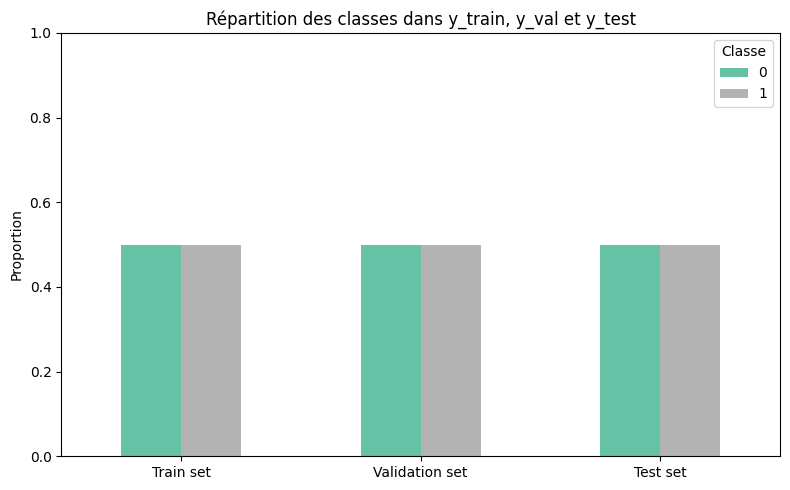

In [ ]:
X_train_tfidf, X_valid_tfidf, X_test_tfidf, y_train_tfidf, y_valid_tfidf, y_test_tfidf = split_train_val_test(tweets_df_tfidf_1gram.item(), Y, sample_size=20000)
print("Répartition dans y_train    :", pd.Series(y_train_tfidf).value_counts(normalize=True))
print("Répartition dans y_validation:", pd.Series(y_valid_tfidf).value_counts(normalize=True))
print("Répartition dans y_test :", pd.Series(y_test_tfidf).value_counts(normalize=True))
plot_distribution(y_train_tfidf, y_valid_tfidf, y_test_tfidf)

In [ ]:
skf.get_n_splits(X_train_tfidf, y_train_tfidf)
for i, (train_index, test_index) in enumerate(skf.split(X_train_tfidf, y_train_tfidf)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[ 2890  2891  2892 ... 11997 11998 11999]
  Test:  index=[   0    1    2 ... 3107 3108 3109]
Fold 1:
  Train: index=[    0     1     2 ... 11997 11998 11999]
  Test:  index=[2890 2891 2892 ... 5997 5999 6000]
Fold 2:
  Train: index=[    0     1     2 ... 11997 11998 11999]
  Test:  index=[5998 6001 6002 ... 8999 9001 9004]
Fold 3:
  Train: index=[   0    1    2 ... 8999 9001 9004]
  Test:  index=[ 8994  8995  9000 ... 11997 11998 11999]


In [ ]:
%%time
tfidf_results_df = evaluate_models(X_train_tfidf, X_valid_tfidf, y_train_tfidf, y_valid_tfidf, cv=skf)

 20%|██        | 1/5 [00:00<00:00,  6.42it/s]

Evaluating Logistic Regression...
Evaluating Ridge Classifier...


 40%|████      | 2/5 [00:00<00:00,  6.86it/s]

Evaluating XGBoost...


 60%|██████    | 3/5 [00:13<00:12,  6.10s/it]

Evaluating LightGBM...


 80%|████████  | 4/5 [00:20<00:06,  6.62s/it]

Evaluating Random Forest...


100%|██████████| 5/5 [01:01<00:00, 12.26s/it]



CPU times: user 1min 15s, sys: 371 ms, total: 1min 15s
Wall time: 1min 1s


In [ ]:
tfidf_results_df

,Model,cv_score,val_score,precision,recall,f1,auc,mse,train_time (s)
1,Ridge Classifier,0.699667,0.71225,0.700141,0.7425,0.720699,0.71225,0.28775,0.135596
0,Logistic Regression,0.703167,0.71025,0.698443,0.7400,0.718621,0.71025,0.28975,0.155694
3,LightGBM,0.698083,0.70150,0.685373,0.7450,0.713943,0.70150,0.29850,7.412414
2,XGBoost,0.693667,0.68900,0.668449,0.7500,0.706880,0.68900,0.31100,13.181984
4,Random Forest,0.694083,0.68900,0.691296,0.6830,0.687123,0.68900,0.31100,40.386735


## | Word2Vec

Répartition dans y_train    : 1    0.500083
0    0.499917
Name: proportion, dtype: float64
Répartition dans y_validation: 0    0.5
1    0.5
Name: proportion, dtype: float64
Répartition dans y_test : 1    0.5
0    0.5
Name: proportion, dtype: float64


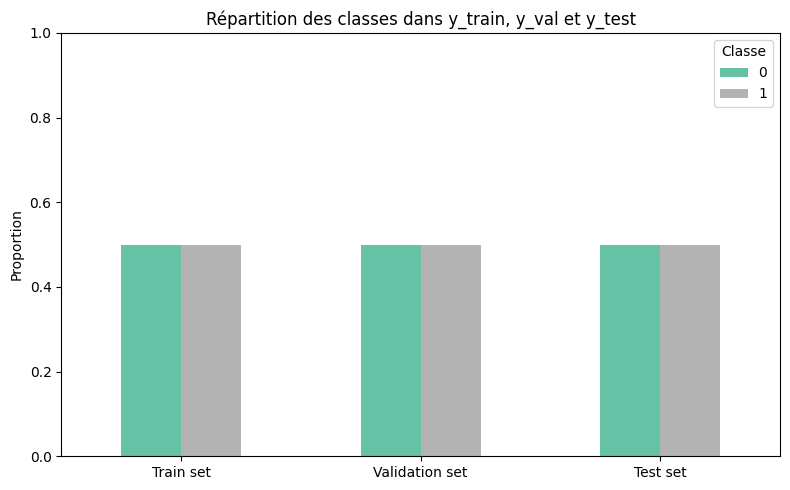

CPU times: user 3.05 s, sys: 9.79 s, total: 12.8 s
Wall time: 1min 3s


In [9]:
%%time
X_train_w2v, X_valid_w2v, X_test_w2v, y_train_w2v, y_valid_w2v, y_test_w2v = split_train_val_test(tweets_embeddings_word2vec, Y, sample_size=20000)
print("Répartition dans y_train    :", pd.Series(y_train_w2v).value_counts(normalize=True))
print("Répartition dans y_validation:", pd.Series(y_valid_w2v).value_counts(normalize=True))
print("Répartition dans y_test :", pd.Series(y_test_w2v).value_counts(normalize=True))
plot_distribution(y_train_w2v, y_valid_w2v,  y_test_w2v)

In [ ]:
%%time
w2v_results__df = evaluate_models(X_train_w2v, X_valid_w2v, y_train_w2v, y_valid_w2v, cv=skf)

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Logistic Regression...


 20%|██        | 1/5 [00:18<01:14, 18.60s/it]

Evaluating Ridge Classifier...


 40%|████      | 2/5 [00:19<00:24,  8.21s/it]

Evaluating XGBoost...


 60%|██████    | 3/5 [01:43<01:25, 42.62s/it]

Evaluating LightGBM...


 80%|████████  | 4/5 [02:23<00:41, 41.77s/it]

Evaluating Random Forest...


100%|██████████| 5/5 [04:29<00:00, 53.87s/it]



CPU times: user 6min 12s, sys: 1.6 s, total: 6min 14s
Wall time: 4min 29s


In [ ]:
w2v_results__df

,Model,cv_score,val_score,precision,recall,f1,auc,mse,train_time (s)
0,Logistic Regression,0.720917,0.72775,0.721655,0.7415,0.731443,0.72775,0.27225,18.597020
1,Ridge Classifier,0.716833,0.72250,0.717285,0.7345,0.725791,0.72250,0.27750,0.935626
3,LightGBM,0.711083,0.69725,0.699142,0.6925,0.695805,0.69725,0.30275,40.463776
2,XGBoost,0.697333,0.69375,0.698616,0.6815,0.689952,0.69375,0.30625,83.560140
4,Random Forest,0.697250,0.68850,0.703344,0.6520,0.676700,0.68850,0.31150,125.763565


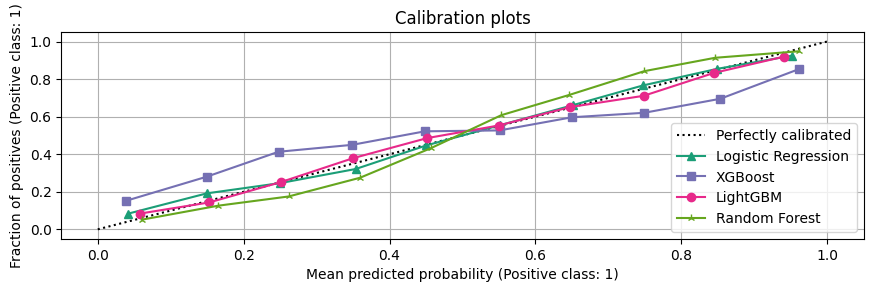

In [ ]:
show_calibration_curve(models, X_test_w2v, y_test_w2v, exclude=["Ridge Classifier"])

## | FastText

In [ ]:
%%time
X_train_ft, X_valid_ft, X_test_ft, y_train_ft, y_valid_ft, y_test_ft = split_train_val_test(tweets_embeddings_fasttext, Y, sample_size=20000)

CPU times: user 20.6 s, sys: 17.5 s, total: 38.1 s
Wall time: 2min 52s


In [ ]:
%%time
ft_results_df = evaluate_models(X_train_ft, X_valid_ft, y_train_ft, y_valid_ft, cv=skf)

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Logistic Regression...


 20%|██        | 1/5 [00:36<02:25, 36.27s/it]

Evaluating Ridge Classifier...


 40%|████      | 2/5 [00:37<00:46, 15.51s/it]

Evaluating XGBoost...


 60%|██████    | 3/5 [02:03<01:35, 47.86s/it]

Evaluating LightGBM...


 80%|████████  | 4/5 [02:45<00:45, 45.40s/it]

Evaluating Random Forest...


100%|██████████| 5/5 [04:50<00:00, 58.19s/it]



CPU times: user 6min 51s, sys: 1.74 s, total: 6min 53s
Wall time: 4min 50s


In [ ]:
display(ft_results_df)

,Model,cv_score,val_score,precision,recall,f1,auc,mse,train_time (s)
0,Logistic Regression,0.719167,0.72125,0.720259,0.7235,0.721876,0.72125,0.27875,36.267372
1,Ridge Classifier,0.714500,0.72100,0.721000,0.7210,0.721000,0.72100,0.27900,0.972697
2,XGBoost,0.696167,0.69600,0.695414,0.6975,0.696455,0.69600,0.30400,86.341797
3,LightGBM,0.701167,0.69525,0.697521,0.6895,0.693488,0.69525,0.30475,41.629077
4,Random Forest,0.689417,0.68475,0.700054,0.6465,0.672212,0.68475,0.31525,125.697958


## Comparaison des modèles

In [ ]:
tfidf_results_df['Corpus'] = 'tfidf'
w2v_results__df['Corpus'] = 'word2vec'
ft_results_df['Corpus'] = 'fasttext'

In [ ]:
res_all_df = pd.concat([tfidf_results_df, w2v_results__df, ft_results_df])
res_all_df.rename(columns={
    "val_score": "Accuracy",
    "f1": "F1-score",
    "auc": "AUC",
    "train_time (s)": "Train Time (s)"
}, inplace=True)

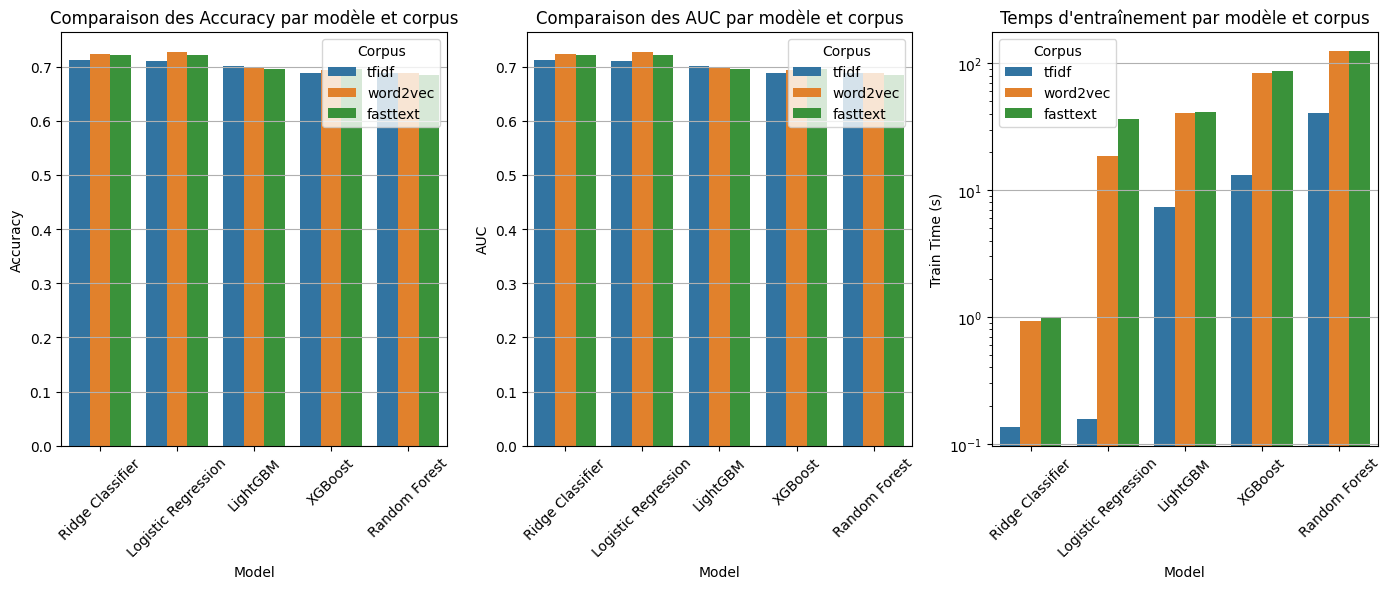

In [ ]:
fig = plt.figure(figsize=(14, 6))

# F1-score
ax = fig.add_subplot(131)
sns.barplot(data=res_all_df, x="Model", y="Accuracy", hue="Corpus")
plt.title("Comparaison des Accuracy par modèle et corpus")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()

# AUC
ax = fig.add_subplot(132)
sns.barplot(data=res_all_df, x="Model", y="AUC", hue="Corpus")
plt.title("Comparaison des AUC par modèle et corpus")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()

# Train Time
ax = fig.add_subplot(133)
sns.barplot(data=res_all_df, x="Model", y="Train Time (s)", hue="Corpus")
plt.title("Temps d'entraînement par modèle et corpus")
plt.xticks(rotation=45)
plt.yscale("log")
plt.grid(axis="y")
plt.tight_layout()

plt.show()

In [ ]:
del tfidf_results_df
del w2v_results__df
del ft_results_df
del X_test_tfidf
del X_valid_tfidf
del X_train_tfidf
del y_valid_tfidf
del y_train_tfidf
del y_test_tfidf

**Conclusion**: Parmi l’ensemble des modèles testés sur les trois représentations textuelles, **Logistic Regression avec Word2Vec** obtient les meilleurs résultats en termes de F1-score et d’AUC.
Il offre un excellent compromis entre performance et robustesse, tout en restant simple à entraîner.
Nous le retenons donc comme **modèle de référence pour cette prémiére approche**.


## Optimisation du modéle 1: Logistic Regression + Word2vec

In [ ]:
!pip install optuna
import optuna

In [ ]:
def objective(trial):
    # Hyperparamètres à optimiser
    C = trial.suggest_loguniform('C', 1e-2, 1e2)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', None])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])

    # Only needed if penalty is elasticnet
    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 0.5)

    # Skip invalid combinations manually
    invalid_combo = (
        (penalty == 'l1' and solver not in ['liblinear', 'saga']) or
        (penalty == 'elasticnet' and solver != 'saga') or
        (penalty == 'none' and solver == 'liblinear')
    )
    # Skip invalid combinations manually
    invalid_combo = (
        (penalty == 'l1' and solver not in ['liblinear', 'saga']) or
        (penalty == 'elasticnet' and solver != 'saga') or
        (penalty == None and solver == 'liblinear')
    )

    if invalid_combo:
        return 0.0

    # Modèle
    model = LogisticRegression(
        C=C,
        penalty=penalty,
        class_weight=class_weight,
        max_iter=1000,
        solver=solver,
        l1_ratio=l1_ratio,
        random_state=42
    )

    # Cross-validation
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_w2v, y_train_w2v, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

In [ ]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25, n_jobs=-1)

[I 2025-05-17 21:25:23,391] A new study created in memory with name: no-name-3838aabc-a169-43f0-a134-b03971fa3891
[I 2025-05-17 21:25:41,876] Trial 1 finished with value: 0.7183333333333334 and parameters: {'C': 0.4001041960316794, 'penalty': 'l2', 'class_weight': None, 'solver': 'liblinear'}. Best is trial 1 with value: 0.7183333333333334.
[I 2025-05-17 21:25:44,983] Trial 0 finished with value: 0.71925 and parameters: {'C': 0.025699829117043216, 'penalty': 'l2', 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 0 with value: 0.71925.
[I 2025-05-17 21:25:46,359] Trial 2 finished with value: 0.7193333333333334 and parameters: {'C': 0.09347389563665467, 'penalty': 'l1', 'class_weight': None, 'solver': 'liblinear'}. Best is trial 2 with value: 0.7193333333333334.
[I 2025-05-17 21:28:07,281] Trial 3 finished with value: 0.7181666666666666 and parameters: {'C': 0.6280046603347998, 'penalty': 'elasticnet', 'class_weight': 'balanced', 'solver': 'saga', 'l1_ratio': 0.32859527488318

CPU times: user 1min 30s, sys: 3.11 s, total: 1min 33s
Wall time: 11min 47s


In [ ]:
print("Best score (F1):", study.best_value)
print("Best params:", study.best_params)

Best score (F1): 0.7200833333333333
Best params: {'C': 0.017986470213517514, 'penalty': 'l2', 'class_weight': 'balanced', 'solver': 'liblinear'}


In [ ]:
# La relation entre chaque hyperparamètre et la valeur de la fonction objectif.
optuna.visualization.plot_slice(study)

In [ ]:
from sklearn.metrics import classification_report

lr_model = LogisticRegression(**study.best_params, max_iter=1000)
lr_model.fit(X_train_w2v, y_train_w2v)

# prédiction
y_pred = lr_model.predict(X_valid_w2v)

# évaluation
print("Accuracy:", accuracy_score(y_valid_w2v, y_pred))
print(classification_report(y_valid_w2v, y_pred))

Accuracy: 0.72075
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      2000
           1       0.72      0.72      0.72      2000

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000



> Validation avec Test set

In [ ]:
y_pred = lr_model.predict(X_test_w2v)
print("Accuracy:", accuracy_score(y_test_w2v, y_pred))
print(classification_report(y_test_w2v, y_pred))

Accuracy: 0.7285
              precision    recall  f1-score   support

           0       0.73      0.72      0.73      2000
           1       0.73      0.73      0.73      2000

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



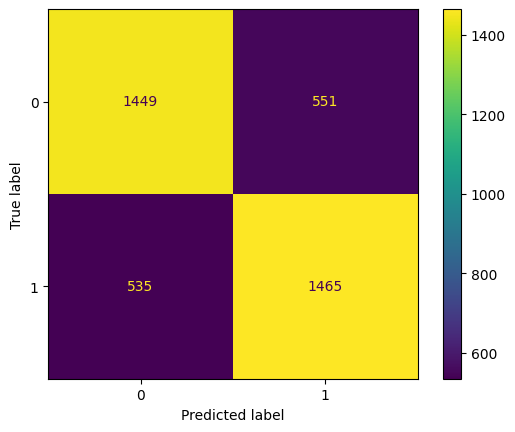

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(lr_model, X_test_w2v, y_test_w2v)
plt.show()

> Sauvegarde du modéle 1

In [ ]:
%%time
import pickle
pickle.dump(lr_model, open(os.path.join(path, "lr_model.pkl"), "wb"))
del lr_model

# Approche 2: Modèle sur mesure avancé (Reseau de Neurone)

In [13]:
tokenized_tweets = pd.read_csv(os.path.join(path, "tokenized_tweets.csv"))

In [14]:
tokenized_tweets.head()

,tokenized_tweets
0,"['switchfoot', 'awww', 'bummer', 'shoulda', 'g..."
1,"['upset', 'update', 'facebook', 'texting', 'mi..."
2,"['kenichan', 'dived', 'many', 'time', 'ball', ..."
3,"['whole', 'body', 'feel', 'itchy', 'like', 'fi..."
4,"['nationwideclass', 'behave', 'mad', 'see']"


In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input

def build_model(weights=None, input_shape=(16, 300)):
  model = Sequential()

  model.add(Input(shape=input_shape))
  model.add(Bidirectional(LSTM(32, return_sequences=False)))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))  # pour classification binaire

  return model

def sentence_to_sequence(tokens, model_embedding, max_len=30, dim=300):
    vectors = [model_embedding.wv[word] if word in model_embedding.wv else np.zeros(dim) for word in tokens]
    # Padding or trimming
    vectors = vectors[:max_len] + [np.zeros(dim)] * (max_len - len(vectors))
    return np.array(vectors)

## | Word2Vec



> Chargement du modéle pretrainé de Word2vec



In [16]:
%%time
w2v_model = Word2Vec.load(os.path.join(path, "word2vec_model.model"))

CPU times: user 6.67 s, sys: 2.41 s, total: 9.08 s
Wall time: 14.9 s


In [58]:
%%time
train_token, val_token, test_token, y_train_w2v, y_valid_w2v, y_test_w2v = split_train_val_test(tokenized_tweets.tokenized_tweets, Y, sample_size=20000)

CPU times: user 1.44 s, sys: 114 ms, total: 1.56 s
Wall time: 1.56 s


In [23]:
max_len = max(map(len, tokenized_tweets))
print(f"Le tweet le plus long contient {max_len} tokens")

Le tweet le plus long contient 16 tokens




> Extracion des sequences



In [35]:
%%time
train_w2v_set =  np.array([sentence_to_sequence(sentence, w2v_model, max_len=max_len) for sentence in train_token])
val_w2v_set =  np.array([sentence_to_sequence(sentence, w2v_model, max_len=max_len) for sentence in val_token])
test_w2v_set =  np.array([sentence_to_sequence(sentence, w2v_model, max_len=max_len) for sentence in test_token])

CPU times: user 3.17 s, sys: 544 ms, total: 3.71 s
Wall time: 3.73 s


In [34]:
train_w2v_set.shape

(12000, 16, 300)

In [67]:
%%time
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 64)             │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,361 (341.25 KB)

 Trainable params: 87,361 (341.25 KB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 103 ms, sys: 2.65 ms, total: 106 ms
Wall time: 103 ms


In [68]:
%%time

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

history = model.fit(
    x=train_w2v_set,
    y=y_train_w2v,
    epochs=30,
    batch_size=32,
    validation_data=(val_w2v_set, y_valid_w2v),
    callbacks=callbacks
)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.5157 - loss: 0.6954 - val_accuracy: 0.5452 - val_loss: 0.6901
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5328 - loss: 0.6914 - val_accuracy: 0.5410 - val_loss: 0.6873
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5596 - loss: 0.6856 - val_accuracy: 0.5617 - val_loss: 0.6841
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5654 - loss: 0.6789 - val_accuracy: 0.5648 - val_loss: 0.6810
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5884 - loss: 0.6702 - val_accuracy: 0.5720 - val_loss: 0.6803
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5884 - loss: 0.6699 - val_accuracy: 0.5710 - val_loss: 0.6771
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5960 - loss: 0.6665 - val_accuracy: 0.5807 - val_loss: 0.6762
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6015 - loss: 0.6601 - val_acc

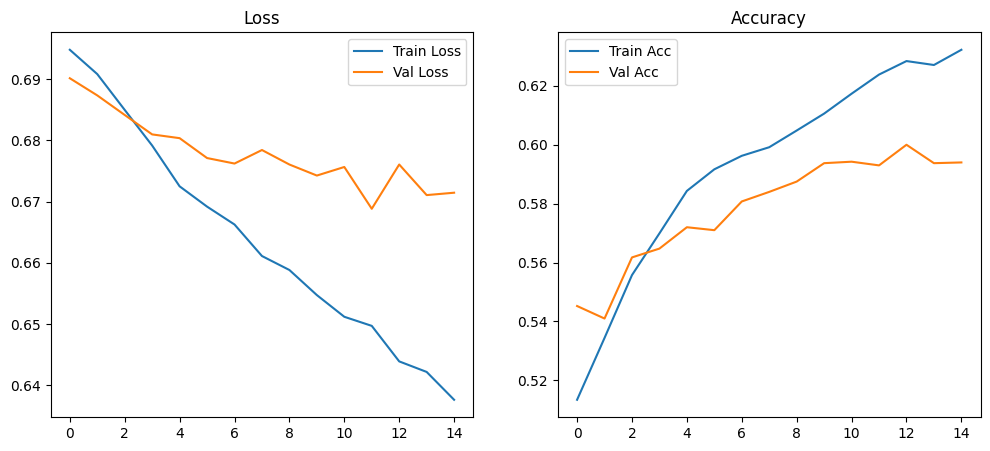

In [69]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

## | FastText